### Made to produce the 2D array plots for differing q_cut and q_thr

In [1]:
import sys,os,os.path
sys.path.append("../../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



### Functions to convert sophronia data to lowTh for use here

In [3]:


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5, verbose = True):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())
    if (verbose == True):
        print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (verbose == True):
            if (len(soph_hitc_list)%j == 50): 
                print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df


def q_cut_beersheba_dict(q_cut_val):
    '''
    Creates dictionary with adjusted q_cut parameter.
    '''

    deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'../../../Tl_studies/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = q_cut_val,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 6e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 100,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1., 0.2),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  


    return deconv_params

### All the sophronia files here

In [4]:
directory = f'../../../next_misc/Tl_studies/sophronia/'

soph_array =    ['sophronia_qthr1.h5', 
                 'sophronia_qthr2.h5', 
                 'sophronia_qthr3.h5', 
                 'sophronia_qthr4.h5', 
                 'sophronia_qthr5.h5']

pre_dir_name = 'q_thr_cut_plots/'

thresholds = [1,2,3,4,5]


deconv_param_array = []
lowTh_array = []

#### Choose event of interest:

In [5]:
# Im choosing this one for the file I've used for conversion because it produces a really nice track :)
event_ids = np.load(f'../quick_notebooks/z_slice/positron_event_ids.npy')
EVENT = event_ids[4]

In [6]:
# collect the event of interest from each file
for i in range(len(soph_array)):

    print("Processing threshold: " + str(thresholds[i]))

    soph_hdst = directory + soph_array[i]
    hdst = dstio.load_dst(soph_hdst, 'RECO', 'Events')
    
    # now take the relevant event only
    hdst = (hdst[hdst['event'] == EVENT])

    # generate as sophronia files
    lowTh_array.append(soph_to_lowTh(hdst, threshold = thresholds[i], verbose = False))

    # collect the dictionaries for the beersheba parameters
    deconv_param_array.append(q_cut_beersheba_dict(thresholds[i]))
    

Processing threshold: 1
Processing threshold: 2
Processing threshold: 3
Processing threshold: 4
Processing threshold: 5


In [8]:
display(lowTh_array[1])

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,-194.375,-287.675,0.0,0.0,549.657471,2.666667,12.000000,-1,0.000040,-1,-1
1,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,-23.325,412.075,0.0,0.0,550.878601,2.318841,41.000000,-1,0.000142,-1,-1
2,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,132.175,396.525,0.0,0.0,551.765076,3.304348,93.000000,-1,0.000327,-1,-1
3,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,-85.525,-132.175,0.0,0.0,552.866394,2.376812,117.142860,-1,0.000453,-1,-1
4,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,-69.975,474.275,0.0,0.0,552.866394,2.086957,102.857148,-1,0.000398,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,178.825,349.875,0.0,0.0,755.285095,2.724638,18.277779,-1,0.000063,-1,-1
2405,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,318.775,241.025,0.0,0.0,755.285095,3.420290,22.944444,-1,0.000079,-1,-1
2406,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,225.475,-163.275,0.0,0.0,756.284973,2.492754,11.576923,-1,0.000040,-1,-1
2407,2140060,2.140062e+12,0.0,203.171747,382.364543,1.0,163.275,474.275,0.0,0.0,756.284973,2.028986,9.423078,-1,0.000033,-1,-1


### Go through beersheba production filling plots
So the idea here is that we want 7 plotted arrays, NxN based on threshold.

Clearly im going to have to collect the data step by step, and hold it until the end, then plot it. Because my current method (of filling the plots as you go along) doesn't seem like a feasible option due to the fact that you can't make the figures parts of an array

We'll be looking at the Y-Z components only otherwise it would be too much information
So run through beersheba with the specific parameters, and save each dataframe
Will need maximum 7 per plot for the different plots:

   - Sensors signal (from hits.Y and hits.Z)
This is separate from the rest as its pre-cut, so we can just plot the threshold ones collectively and save that. With no problems :)
 
    - Cut sensors (for hits_cut)
    - Drop sensors (from hits_cuts)
    - Beersheba deconv (from hits_deco)
    - 3D deconvolved plots 
    - 3D voxelised plots

3D array needed, [q_thr][q_cut][data] will be the shape, in this case, [i][j][7]




In [9]:
# The relevant parameters needed for all beersheba stuff
run_number      = -1
detector_db     = 'localdb.NEXT100DB.sqlite3'
datatype        = 'MC'
pitch = 15.55

Save monte carlo plot first

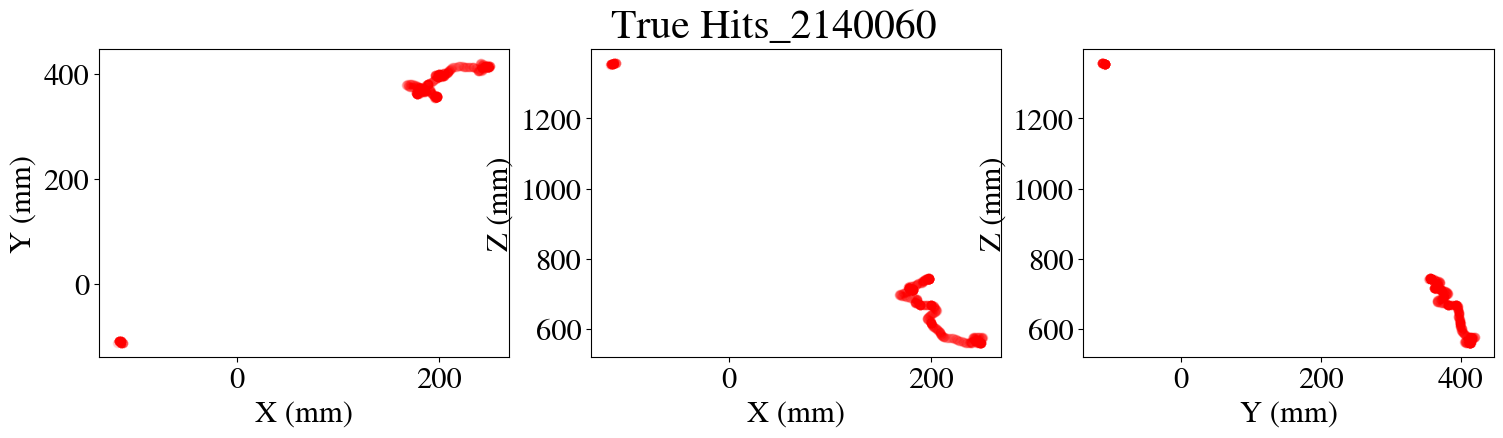

In [10]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_hdst).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_hdst).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == EVENT]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + str(EVENT), fontsize=30)
    fig.savefig(pre_dir_name + "/MC_hits")

In [11]:
# create 3D array
data_array = np.empty((len(thresholds), len(thresholds), 2), dtype=tuple)

'''
DATA ARRAY SETUP (wrt the last element)
0 - q_cut
1 - drop
2 - beersheba_deconv parameters (used for all the beersheba plots)
'''


# and sensor signal one as its pre-cuts
sensor_signal = np.empty(len(thresholds), dtype = tuple)

#print(data_array)
#print(data_array[0][0][0])
#print(sensor_signal)

In [12]:
# q_thr loop (represented by lowTh_array)
for i in range(len(thresholds)):

    print("q_thr: {}".format(thresholds[i]))

    hits = lowTh_array[i]
    
    # sensor signal section
    # this will be altered by its interaction with sophronia (q_thr), but has no
    # relation to the cuts, so can be saved in a smaller array
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()

    sensor_signal[i] = [hits.Y, hits.Z, yy, zz, hits.Q]


    # q_cut loop (applied by the deconv parameters dictionaries)
    for j in range(len(thresholds)):

        # reiterated, just in case things get confused
        hits = lowTh_array[i]

        #### Q CUT ####

        # selecting the q_cut
        qmin = deconv_param_array[j]['q_cut']

        cut_sensors       = beerfun.cut_over_Q(deconv_param_array[j]['q_cut'], ['E', 'Ec'])

        print(f'Cutting sensors below {qmin}')

        hits_cut = coref.timefunc(cut_sensors)(hits.copy())

        # fill this array component
        data_array[i][j][0] = [hits_cut.Y, hits_cut.Z, yy, zz, hits_cut.Q]


        ####  DROP SENSORS  ####

        drop_sensors      = beerfun.drop_isolated(deconv_param_array[j]['drop_dist'], ['E', 'Ec'])
        
        # drop the sensors
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

        # fill in array
        data_array[i][j][1] = [hits_drop.Y, hits_drop.Z, yy, zz, hits_drop.Q]

        

        


q_thr: 1
Cutting sensors below 1
Time spent in cut_over_Q: 0.01676487922668457 s
Time spent in drop_isolated: 0.3515126705169678 s
Cutting sensors below 2
Time spent in cut_over_Q: 0.008476495742797852 s
Time spent in drop_isolated: 0.04286527633666992 s
Cutting sensors below 3
Time spent in cut_over_Q: 0.008283853530883789 s
Time spent in drop_isolated: 0.021222591400146484 s
Cutting sensors below 4
Time spent in cut_over_Q: 0.00669407844543457 s
Time spent in drop_isolated: 0.013103008270263672 s
Cutting sensors below 5
Time spent in cut_over_Q: 0.00886225700378418 s
Time spent in drop_isolated: 0.00972604751586914 s
q_thr: 2
Cutting sensors below 1
Time spent in cut_over_Q: 0.005715608596801758 s
Time spent in drop_isolated: 0.04714322090148926 s
Cutting sensors below 2
Time spent in cut_over_Q: 0.004822492599487305 s
Time spent in drop_isolated: 0.048583269119262695 s
Cutting sensors below 3
Time spent in cut_over_Q: 0.00504612922668457 s
Time spent in drop_isolated: 0.023498773574

### Sensor signal plot

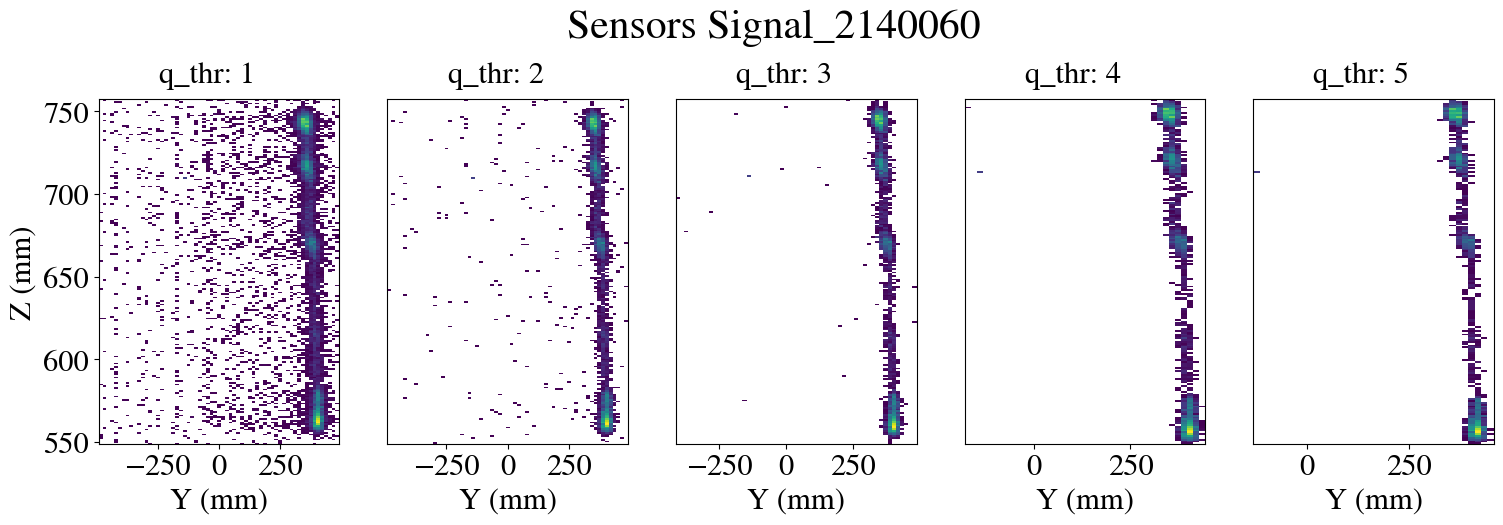

In [13]:
fig, axes = plt.subplots(1, 5, figsize = (18,5))
for i in range(len(thresholds)):
    h_Y = sensor_signal[i][0]
    h_Z = sensor_signal[i][1]
    yy  = sensor_signal[i][2]
    zz  = sensor_signal[i][3]
    h_Q = sensor_signal[i][4]

    axes[i].hist2d(h_Y, h_Z, bins=[yy, zz], weights=h_Q, cmin=0.0001);
    axes[i].set_xlabel('Y (mm)');
    axes[i].text(0.25, 1.05, "q_thr: " + str(thresholds[i]), transform=axes[i].transAxes)

    

    if (i == 0):
        axes[i].set_ylabel('Z (mm)')
    else:
        axes[i].set_yticks([])

fig.subplots_adjust(top = 0.8)
fig.suptitle('Sensors Signal_' + str(EVENT), fontsize=30)
fig.savefig(pre_dir_name + str('sensor_signal.png'))
plt.show()


### Q_CUT PLOT

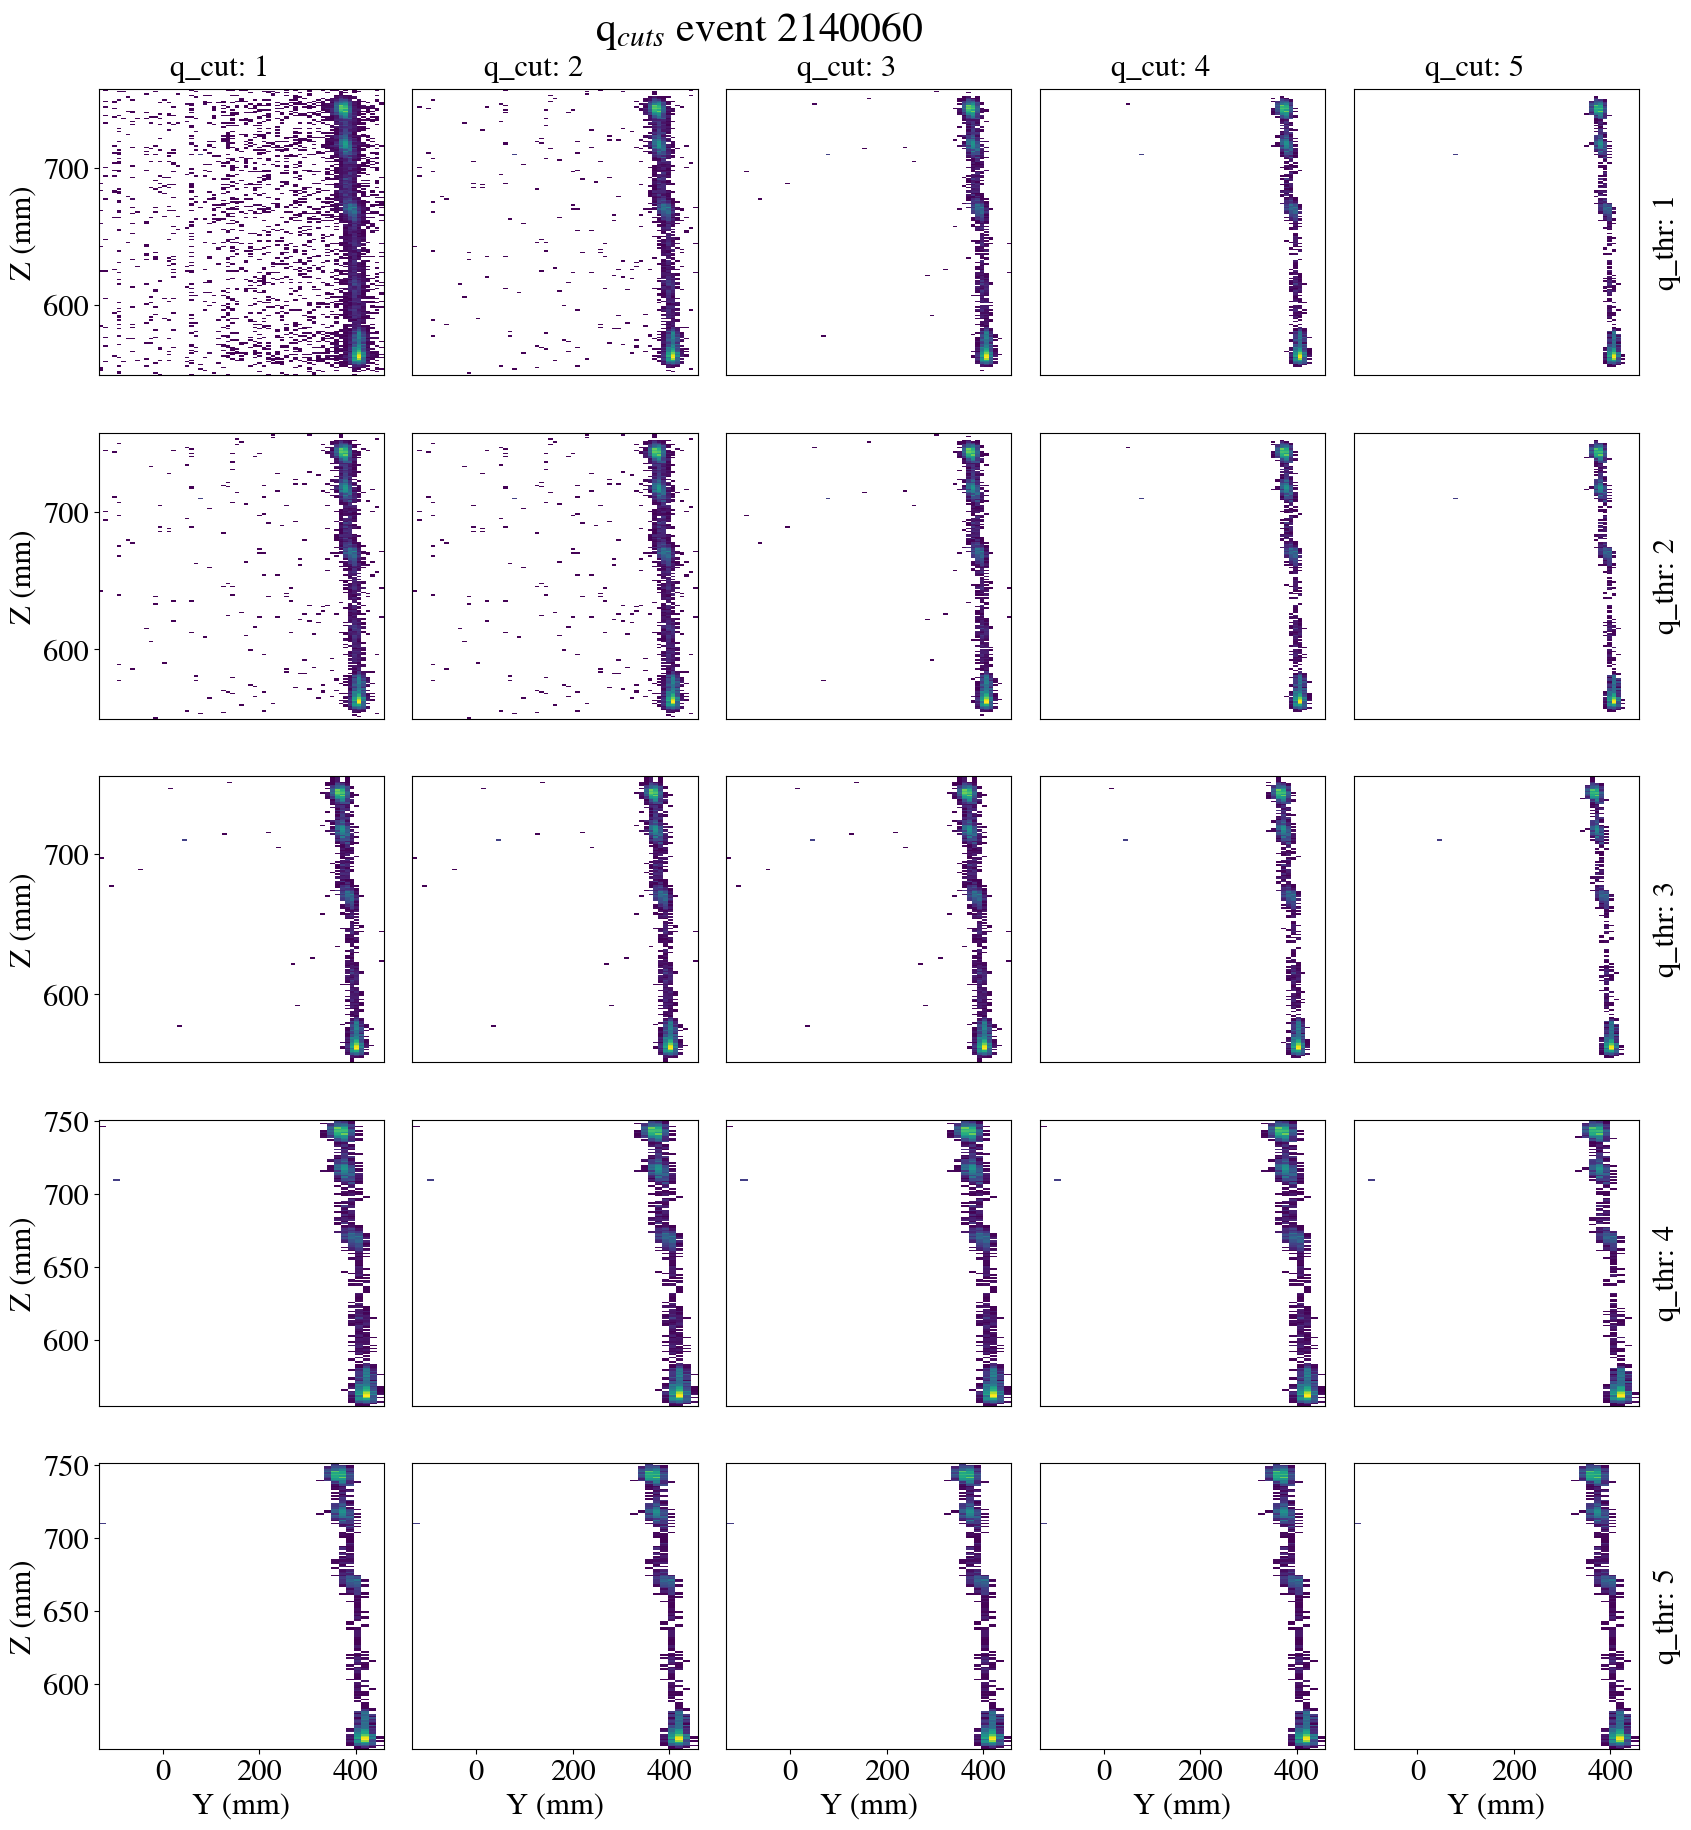

In [14]:
fig, axes = plt.subplots(5, 5, figsize = (22,20))
for i in range(len(thresholds)):
    for j in range(len(thresholds)):
        h_Y = data_array[i][j][0][0]
        h_Z = data_array[i][j][0][1]
        yy  = data_array[i][j][0][2]
        zz  = data_array[i][j][0][3]
        h_Q = data_array[i][j][0][4]

        axes[i][j].hist2d(h_Y, h_Z, bins=[yy, zz], weights=h_Q, cmin=0.0001);
        #axes[i][j].set_xlabel('Y (mm)');


        # threshold labels
        if (i == 0):
            axes[i][j].text(0.25, 1.05, "q_cut: " + str(thresholds[j]), transform=axes[i][j].transAxes)

        if (j == len(thresholds)-1):
            axes[i][j].text(1.125, 0.3, "q_thr: " + str(thresholds[i]), 
                            transform=axes[i][j].transAxes, 
                            rotation = 90, rotation_mode = 'anchor')



        if (i != len(thresholds)-1):
            axes[i][j].set_xticks([])
        else:
            axes[i][j].set_xlabel('Y (mm)')    
            

        if (j != 0):
            axes[i][j].set_yticks([])
        else:
            axes[i][j].set_ylabel('Z (mm)')    
        
# test to understand where the axes actually are
#axes[4][0].text(0.25, 1.05, "test",transform=axes[4][0].transAxes)

fig.subplots_adjust(top = 0.94, wspace = 0.1,  left = 0.2, hspace = 0.2)
fig.suptitle('q$_{cuts}$ event ' + str(EVENT), fontsize=30)
fig.savefig(pre_dir_name + str('q_cuts.png'))
plt.show()

### DROP SENSORS PLOT

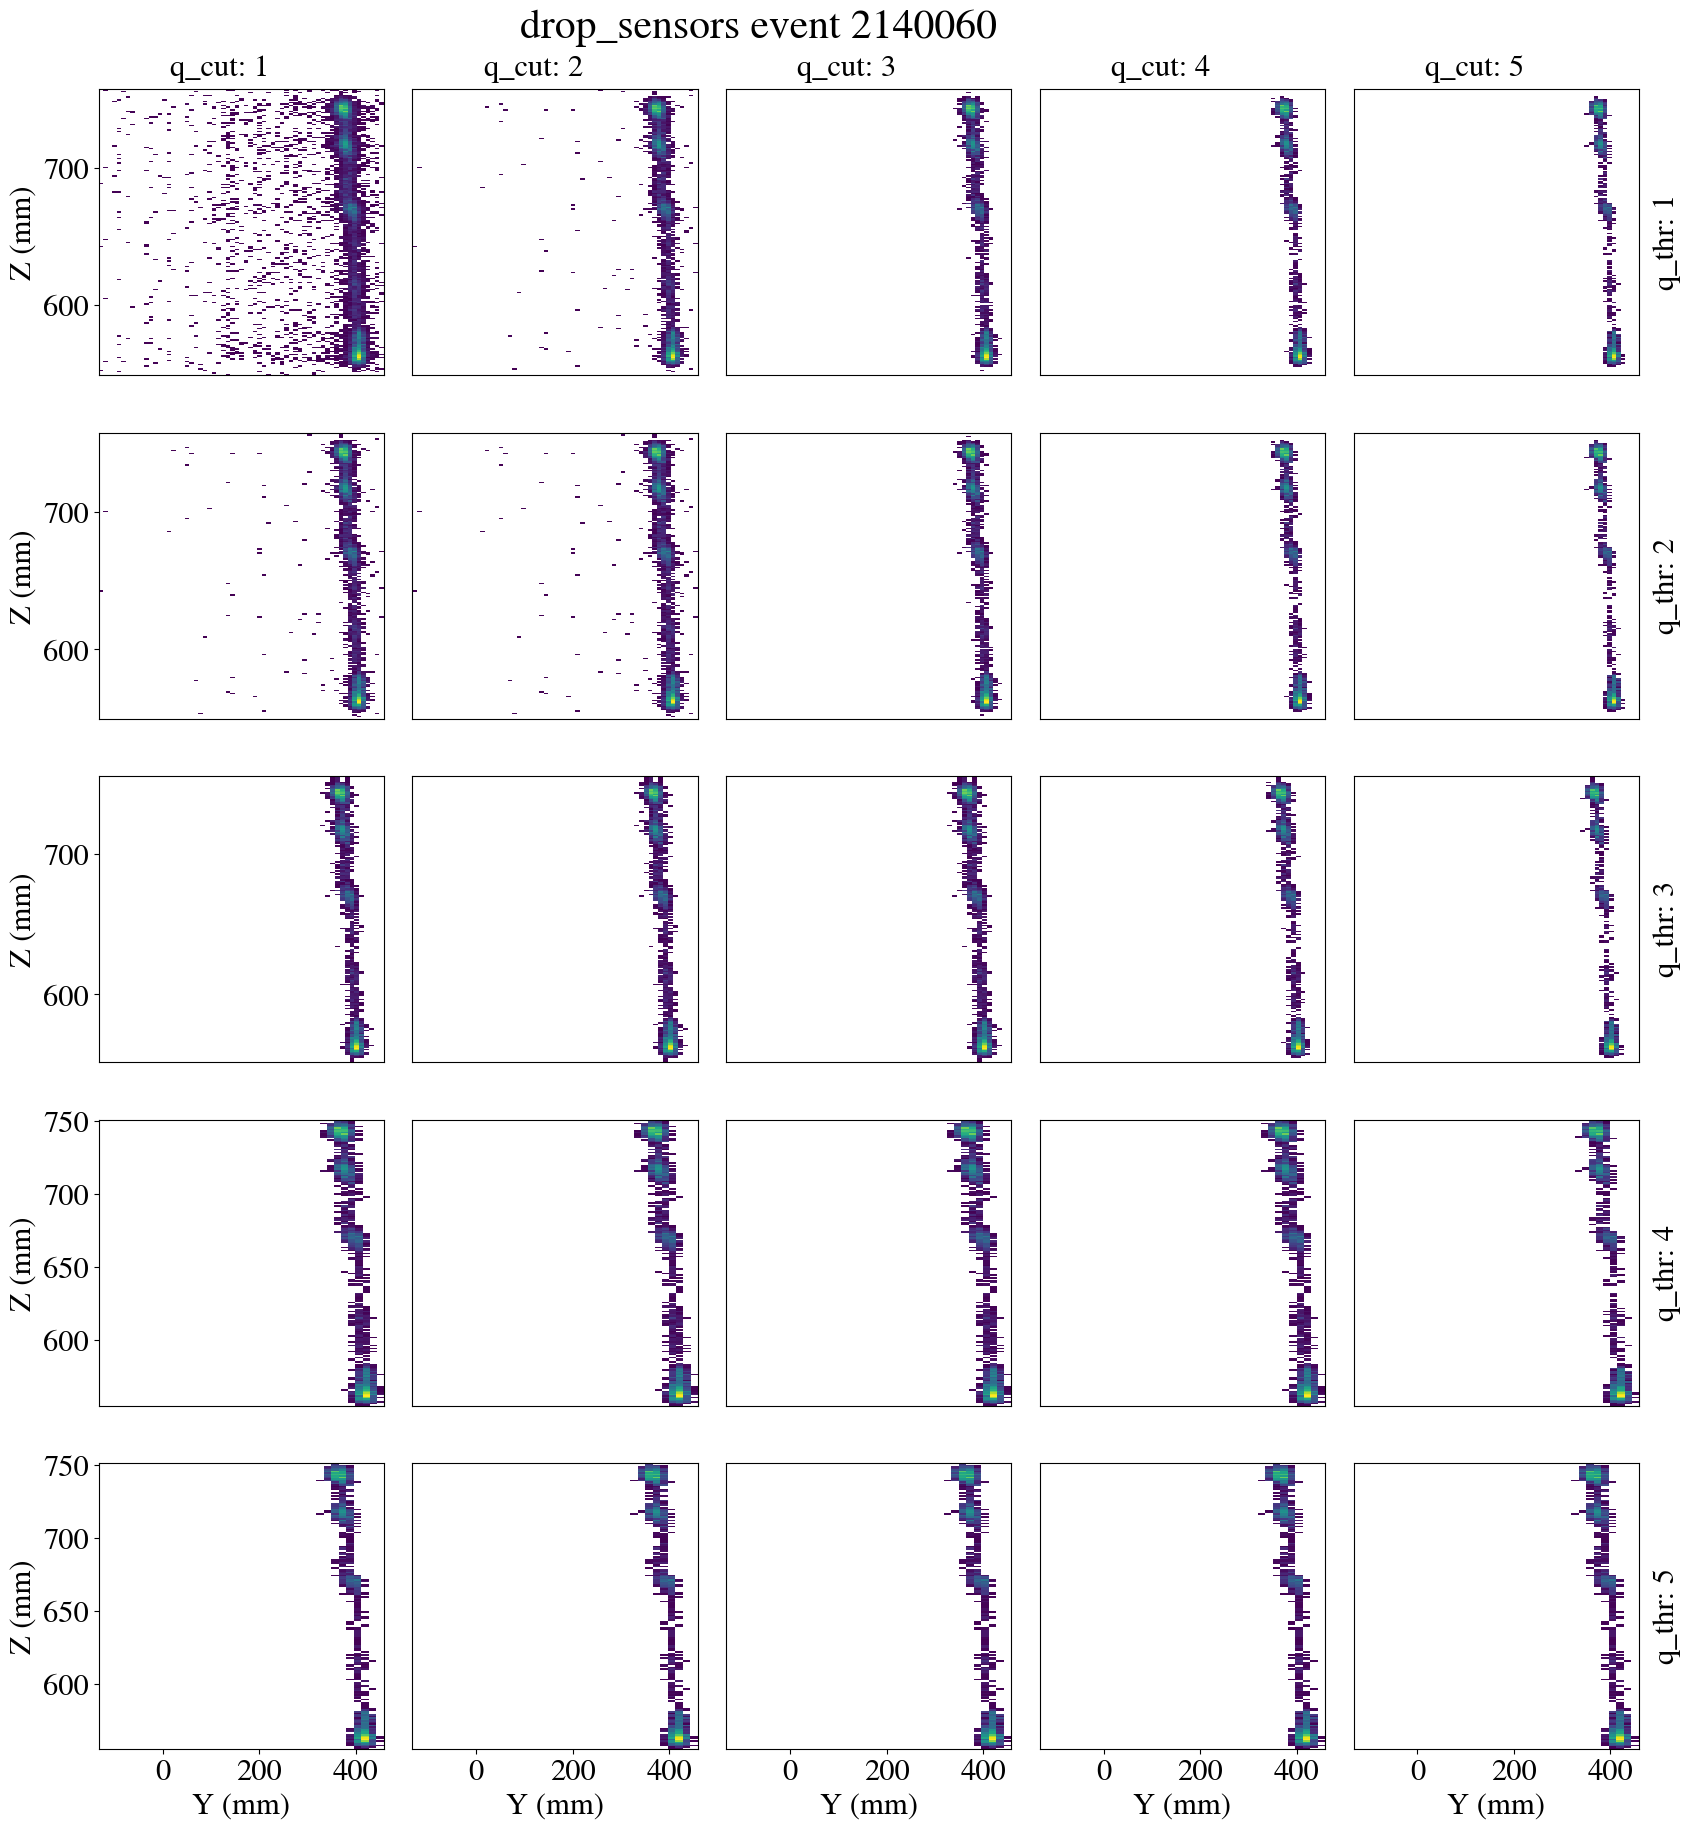

In [15]:
fig, axes = plt.subplots(5, 5, figsize = (22,20))
for i in range(len(thresholds)):
    for j in range(len(thresholds)):
        h_Y = data_array[i][j][1][0]
        h_Z = data_array[i][j][1][1]
        yy  = data_array[i][j][1][2]
        zz  = data_array[i][j][1][3]
        h_Q = data_array[i][j][1][4]

        axes[i][j].hist2d(h_Y, h_Z, bins=[yy, zz], weights=h_Q, cmin=0.0001);
        #axes[i][j].set_xlabel('Y (mm)');


        # threshold labels
        if (i == 0):
            axes[i][j].text(0.25, 1.05, "q_cut: " + str(thresholds[j]), transform=axes[i][j].transAxes)

        if (j == len(thresholds)-1):
            axes[i][j].text(1.125, 0.3, "q_thr: " + str(thresholds[i]), 
                            transform=axes[i][j].transAxes, 
                            rotation = 90, rotation_mode = 'anchor')



        if (i != len(thresholds)-1):
            axes[i][j].set_xticks([])
        else:
            axes[i][j].set_xlabel('Y (mm)')    
            

        if (j != 0):
            axes[i][j].set_yticks([])
        else:
            axes[i][j].set_ylabel('Z (mm)')    
        
# test to understand where the axes actually are
#axes[4][0].text(0.25, 1.05, "test",transform=axes[4][0].transAxes)

fig.subplots_adjust(top = 0.94, wspace = 0.1,  left = 0.2, hspace = 0.2)
fig.suptitle('drop_sensors event ' + str(EVENT), fontsize=30)
fig.savefig(pre_dir_name + str('drop_sensor.png'))
plt.show()

### BEERSHEBA

If its in the same loop it seems to break everything, I can kinda understand why.

Therefore instead its going here and its being thoroughly sanitised

**fix me next**

In [29]:
beersheba_threshold = [1,2,3,4,5]
beersheba_qcut = [3,4,5]

beersheba_data_array = np.empty((len(beersheba_threshold), len(beersheba_qcut)), dtype=tuple)
print(beersheba_data_array)

[[None None None]
 [None None None]
 [None None None]
 [None None None]
 [None None None]]


In [30]:
 # q_thr loop (represented by lowTh_array)
for i in range(len(beersheba_threshold)):
    print("{}%".format((i//len(beersheba_threshold))*100))
    #print("q_thr: {}".format(beersheba_threshold))

    hits_b = lowTh_array[i]


    # q_cut loop (applied by the deconv parameters dictionaries)
    for j in range(len(beersheba_qcut)):
        

        #### Q CUT ####

        # selecting the q_cut
        qmin = beersheba_qcut[j]

        cut_sensors       = beerfun.cut_over_Q(qmin, ['E', 'Ec'])

        #print(f'Cutting sensors below {qmin}')

        hits_cut_b = coref.timefunc(cut_sensors)(hits_b.copy())


        ####  DROP SENSORS  ####

        drop_sensors      = beerfun.drop_isolated(deconv_param_array[j]['drop_dist'], ['E', 'Ec'])
        
        # drop the sensors
        hits_drop_b = coref.timefunc(drop_sensors)(hits_cut_b.copy())

        
        
        ### BEERSHEBA ###

        # you'll need these for the voxelised plots
        xx = np.arange(hits_b.X.min(), hits_b.X.max())
        yy = np.arange(hits_b.Y.min(), hits_b.Y.max())
        zz = hits_b.Z.unique()

        # only run beersheba for the q_thr = 3 and q_cut = 3 and above
        # its clear something is slowing this down a lot, and i think its the noise
        # have to do this for some reason, lets not ask
        deconv_params_   = {k : v for k, v in deconv_param_array[j].items() if k not in ['q_cut', 'drop_dist']}

        


        # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
        if 'save_state' in locals():
            deconv_params_['n_iterations'] = save_state
        else:
            # first time round, so set it
            save_state = deconv_params_['n_iterations']
        #print("Number of iterations" + str(save_state))

        for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
            deconv_params_['n_iterations'] = iterN
            deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
            #print(f'{iterN} iterations')
            hits_deco_b = coref.timefunc(deconvolver)(hits_drop_b.copy())
            
        # fill in array
        beersheba_data_array[i][j] = [hits_deco_b.X, hits_deco_b.Y, hits_deco_b.Z, xx, yy, zz, hits_deco_b.E]
        
      
        
        

q_thr: [1, 2, 3, 4, 5]
Cutting sensors below 3
Time spent in cut_over_Q: 0.013172388076782227 s
Time spent in drop_isolated: 0.030428409576416016 s
Number of iterations100
15 iterations
Time spent in apply_deconvolution: 3.915987968444824 s
30 iterations
Time spent in apply_deconvolution: 6.59964656829834 s
45 iterations
Time spent in apply_deconvolution: 9.27319598197937 s
60 iterations
Time spent in apply_deconvolution: 11.112776756286621 s
75 iterations
Time spent in apply_deconvolution: 12.78654170036316 s
90 iterations
Time spent in apply_deconvolution: 14.927025079727173 s
Cutting sensors below 4
Time spent in cut_over_Q: 0.006506919860839844 s
Time spent in drop_isolated: 0.014420747756958008 s
Number of iterations100
15 iterations
Time spent in apply_deconvolution: 3.222572088241577 s
30 iterations
Time spent in apply_deconvolution: 5.091984033584595 s
45 iterations
Time spent in apply_deconvolution: 7.135101795196533 s
60 iterations
Time spent in apply_deconvolution: 9.0505275

### DECONV PLOTS

In [39]:
# SHAPE OF ARRAY
# data_array[i][j][2] = [hits_deco.X, hits_deco.Y, hits_deco.Z, xx, yy, zz, hits_deco.E]

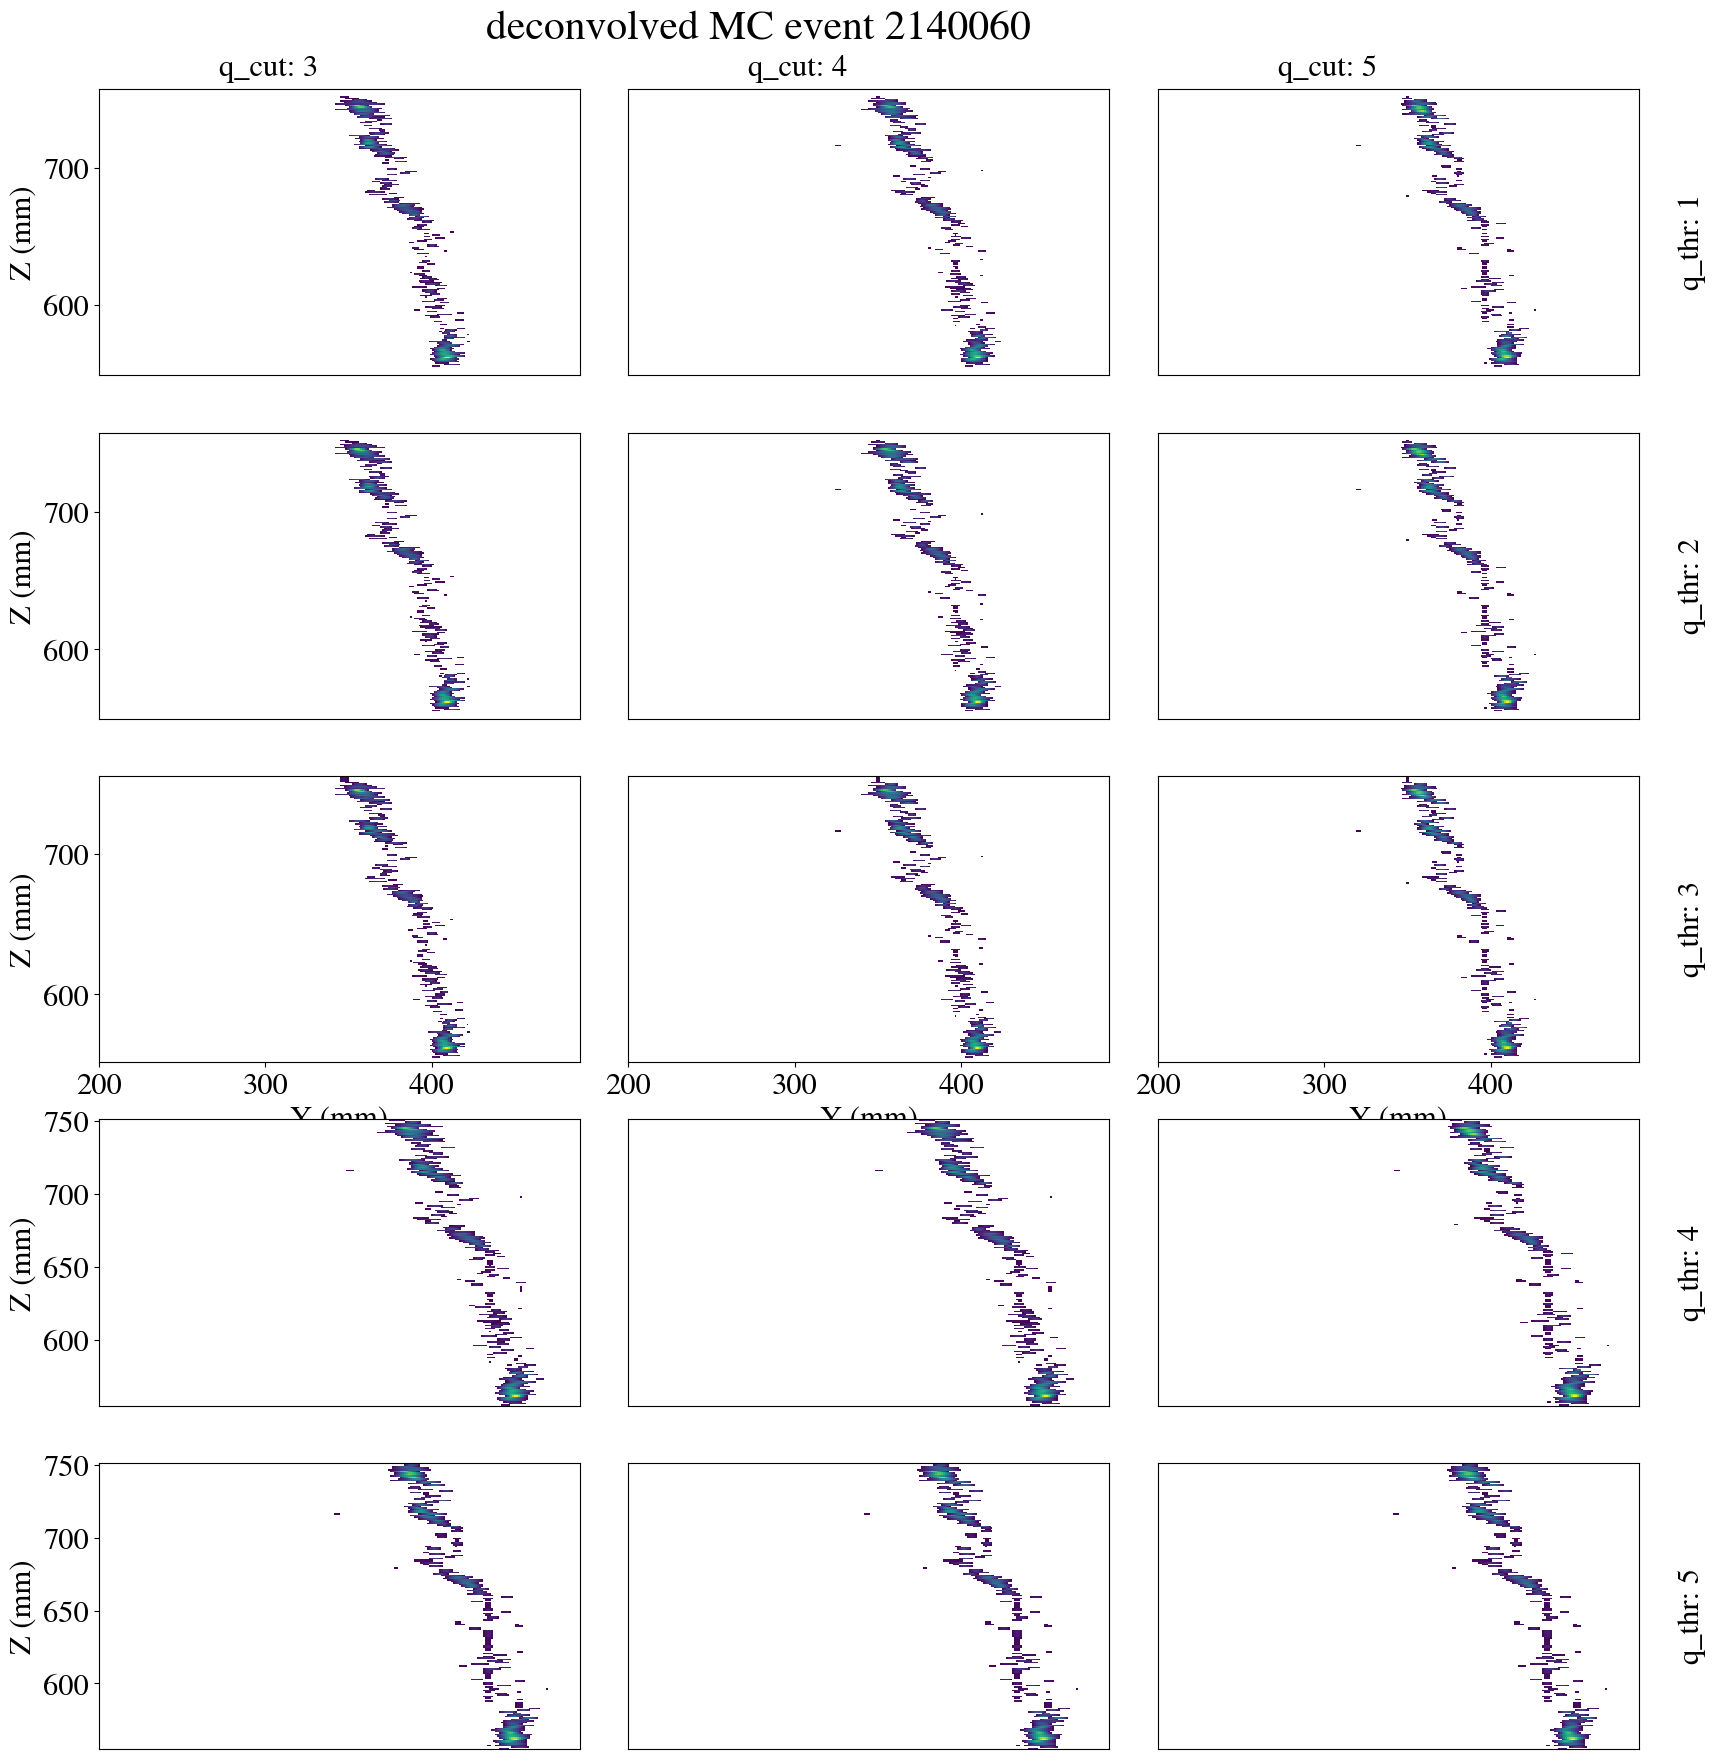

In [33]:
fig, axes = plt.subplots(5, 3, figsize = (22,20))
for i in range(len(beersheba_threshold)):
    for j in range(len(beersheba_qcut)):

        h_Y = beersheba_data_array[i][j][1]
        h_Z = beersheba_data_array[i][j][2]
        yy  = beersheba_data_array[i][j][4]
        zz  = beersheba_data_array[i][j][5]
        h_E = beersheba_data_array[i][j][6]


        axes[i][j].hist2d(h_Y, h_Z, bins=[yy, zz], weights=h_E, cmin=0.0001);
        #axes[i][j].set_xlabel('Y (mm)');

        # threshold labels
        if (i == 0):
            axes[i][j].text(0.25, 1.05, "q_cut: " + str(beersheba_qcut[j]), transform=axes[i][j].transAxes)

        if (j == len(thresholds)-3):
            axes[i][j].text(1.125, 0.3, "q_thr: " + str(beersheba_threshold[i]), 
                            transform=axes[i][j].transAxes, 
                            rotation = 90, rotation_mode = 'anchor')



        if (i != len(thresholds)-3):
            axes[i][j].set_xticks([])
        else:
            axes[i][j].set_xlabel('Y (mm)')    
            

        if (j != 0):
            axes[i][j].set_yticks([])
        else:
            axes[i][j].set_ylabel('Z (mm)')    

        axes[i][j].set_xlim(200)   
        
# test to understand where the axes actually are
#axes[4][0].text(0.25, 1.05, "test",transform=axes[4][0].transAxes)
fig.subplots_adjust(top = 0.94, wspace = 0.1,  left = 0.2, hspace = 0.2)
fig.suptitle('deconvolved MC event ' + str(EVENT), fontsize=30)
fig.savefig(pre_dir_name + str('DECONV_MC_5x3.png'))
plt.show()

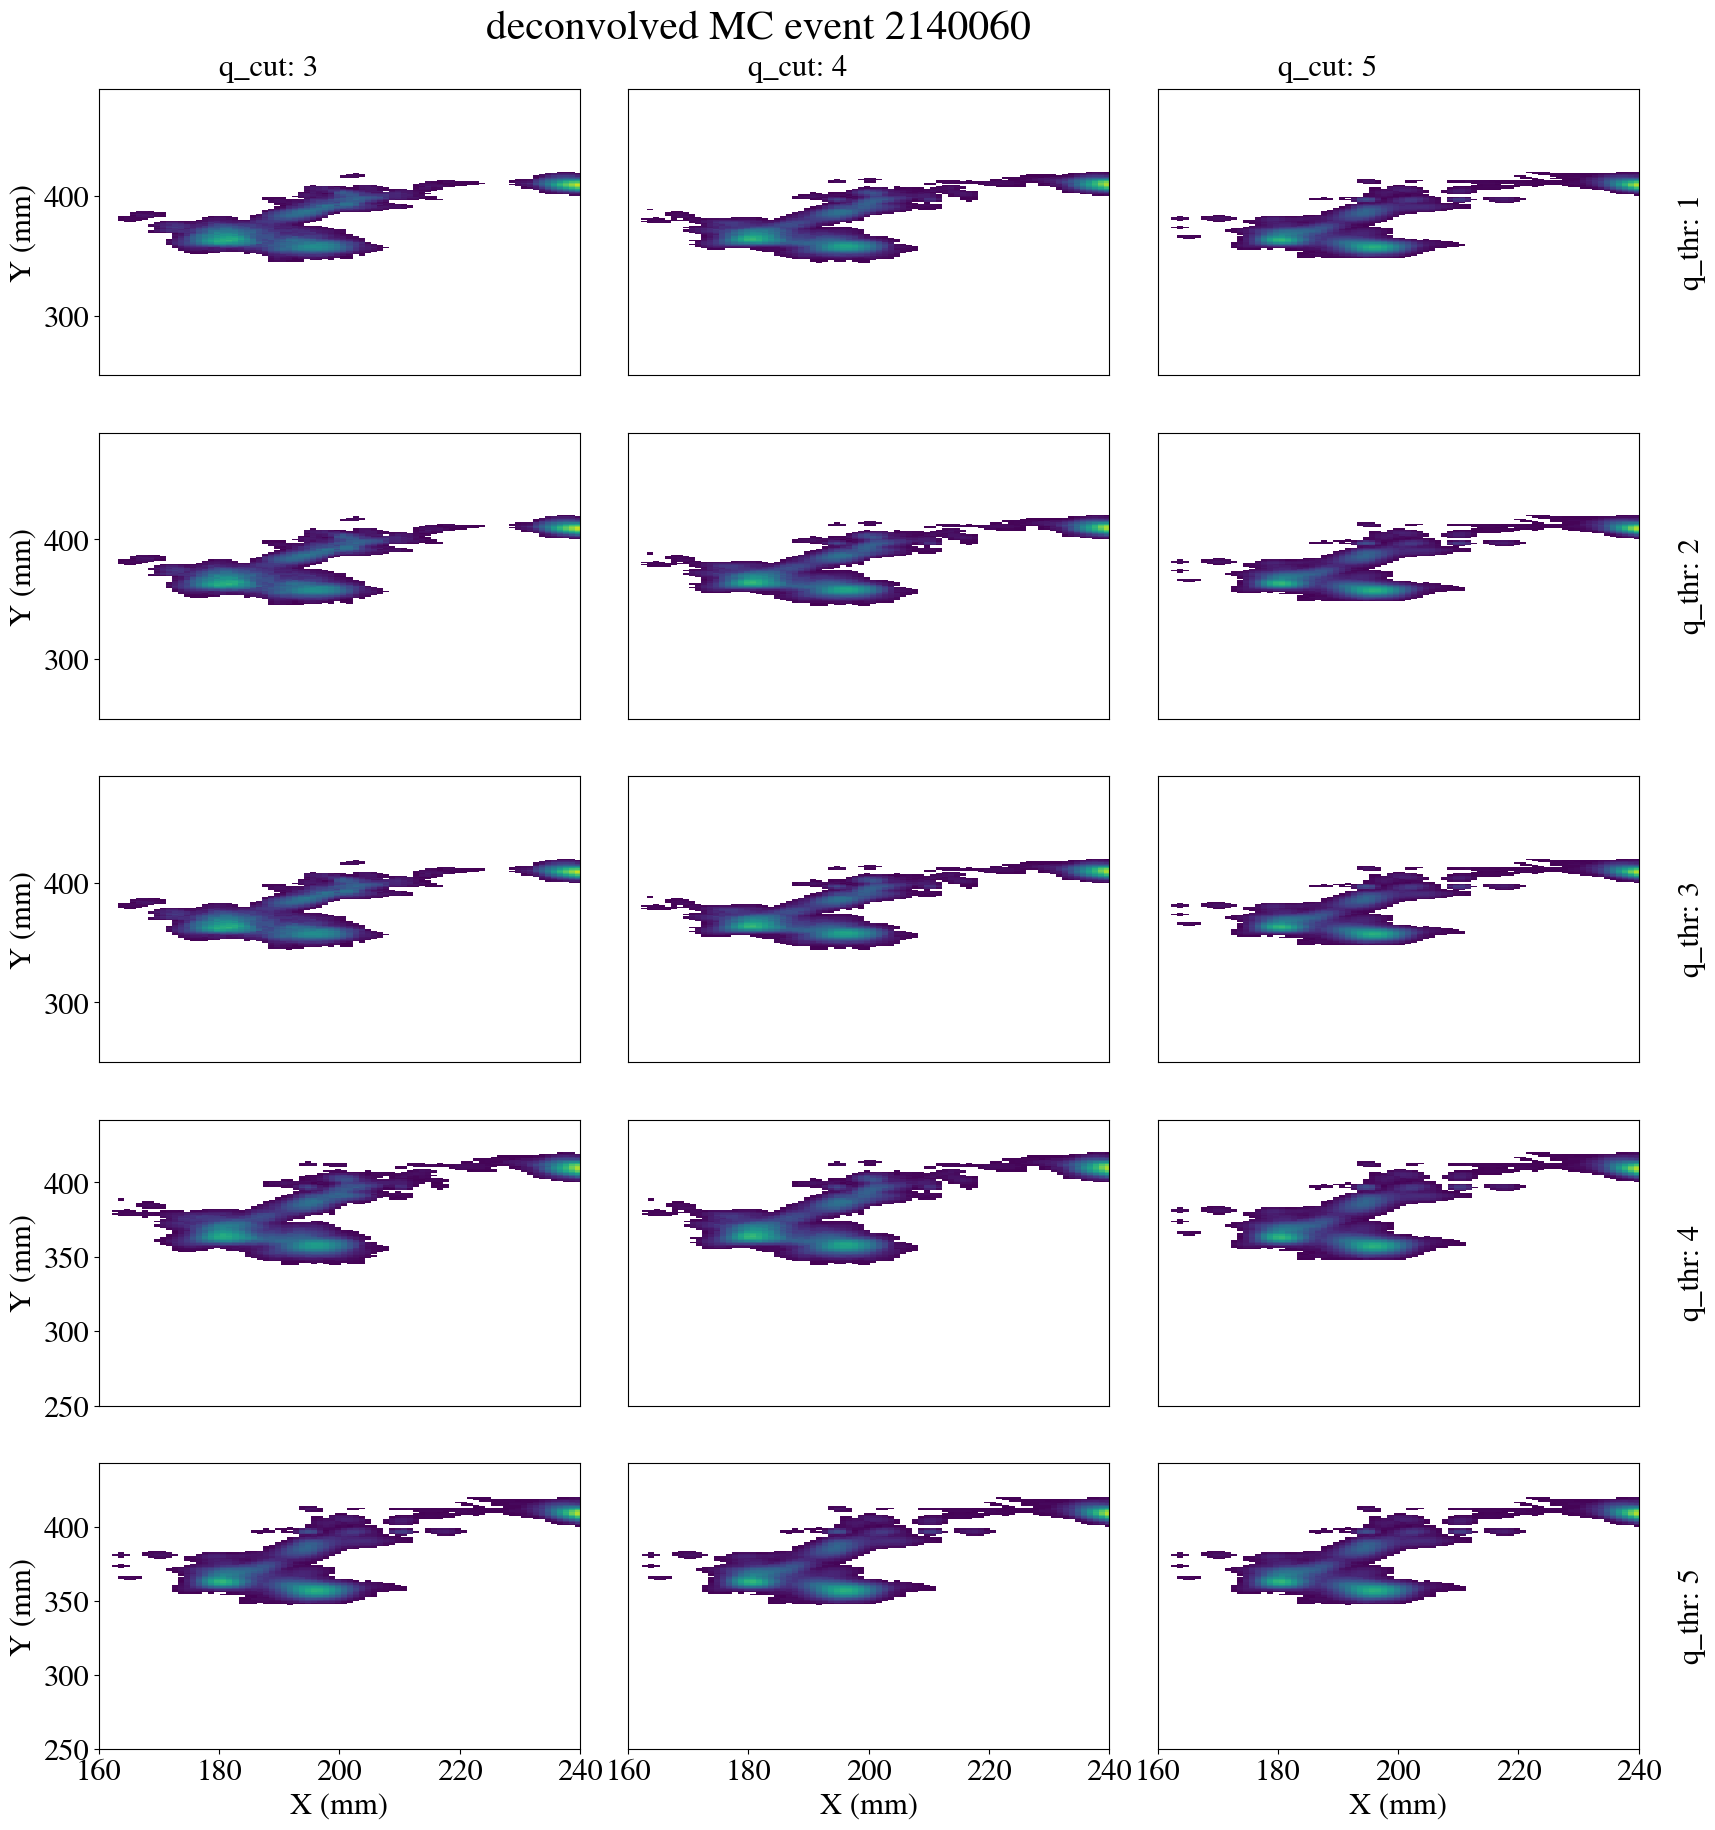

In [46]:
# SHAPE OF ARRAY
# data_array[i][j][2] = [hits_deco.X, hits_deco.Y, hits_deco.Z, xx, yy, zz, hits_deco.E]

fig, axes = plt.subplots(5, 3, figsize = (22,20))
for i in range(len(beersheba_threshold)):
    for j in range(len(beersheba_qcut)):

        h_Y = beersheba_data_array[i][j][0] ## NOW X
        h_Z = beersheba_data_array[i][j][1] ## NOW Y
        yy  = beersheba_data_array[i][j][3]
        zz  = beersheba_data_array[i][j][4]
        h_E = beersheba_data_array[i][j][6]


        axes[i][j].hist2d(h_Y, h_Z, bins=[yy, zz], weights=h_E, cmin=0.0001);
        #axes[i][j].set_xlabel('Y (mm)');

        # threshold labels
        if (i == 0):
            axes[i][j].text(0.25, 1.05, "q_cut: " + str(beersheba_qcut[j]), transform=axes[i][j].transAxes)

        if (j == len(thresholds)-3):
            axes[i][j].text(1.125, 0.3, "q_thr: " + str(beersheba_threshold[i]), 
                            transform=axes[i][j].transAxes, 
                            rotation = 90, rotation_mode = 'anchor')



        if (i != len(beersheba_threshold)-1):
            axes[i][j].set_xticks([])
        else:
            axes[i][j].set_xlabel('X (mm)')    
            

        if (j != 0):
            axes[i][j].set_yticks([])
        else:
            axes[i][j].set_ylabel('Y (mm)')    


        axes[i][j].set_xlim(160, 240)
        axes[i][j].set_ylim(250)

# test to understand where the axes actually are
#axes[4][0].text(0.25, 1.05, "test",transform=axes[4][0].transAxes)
fig.subplots_adjust(top = 0.94, wspace = 0.1,  left = 0.2, hspace = 0.2)
fig.suptitle('deconvolved MC event ' + str(EVENT), fontsize=30)
fig.savefig(pre_dir_name + str('DECONV_MC_5x3_XY.png'))
plt.show()

In [36]:
print(beersheba_data_array[0][0][1])

#h_Y = beersheba_data_array[0][0][1]
#h_Z = beersheba_data_array[0][0][2]
#yy  = beersheba_data_array[i][j][4]
#zz  = beersheba_data_array[i][j][5]
#h_E = beersheba_data_array[i][j][6]

0        402.675
1        403.675
2        401.675
3        402.675
4        403.675
          ...   
12771    348.675
12772    349.675
12773    346.675
12774    347.675
12775    348.675
Name: Y, Length: 12776, dtype: float64


### Q_CUT PLOT BUT FOCUSED
On region y > 200

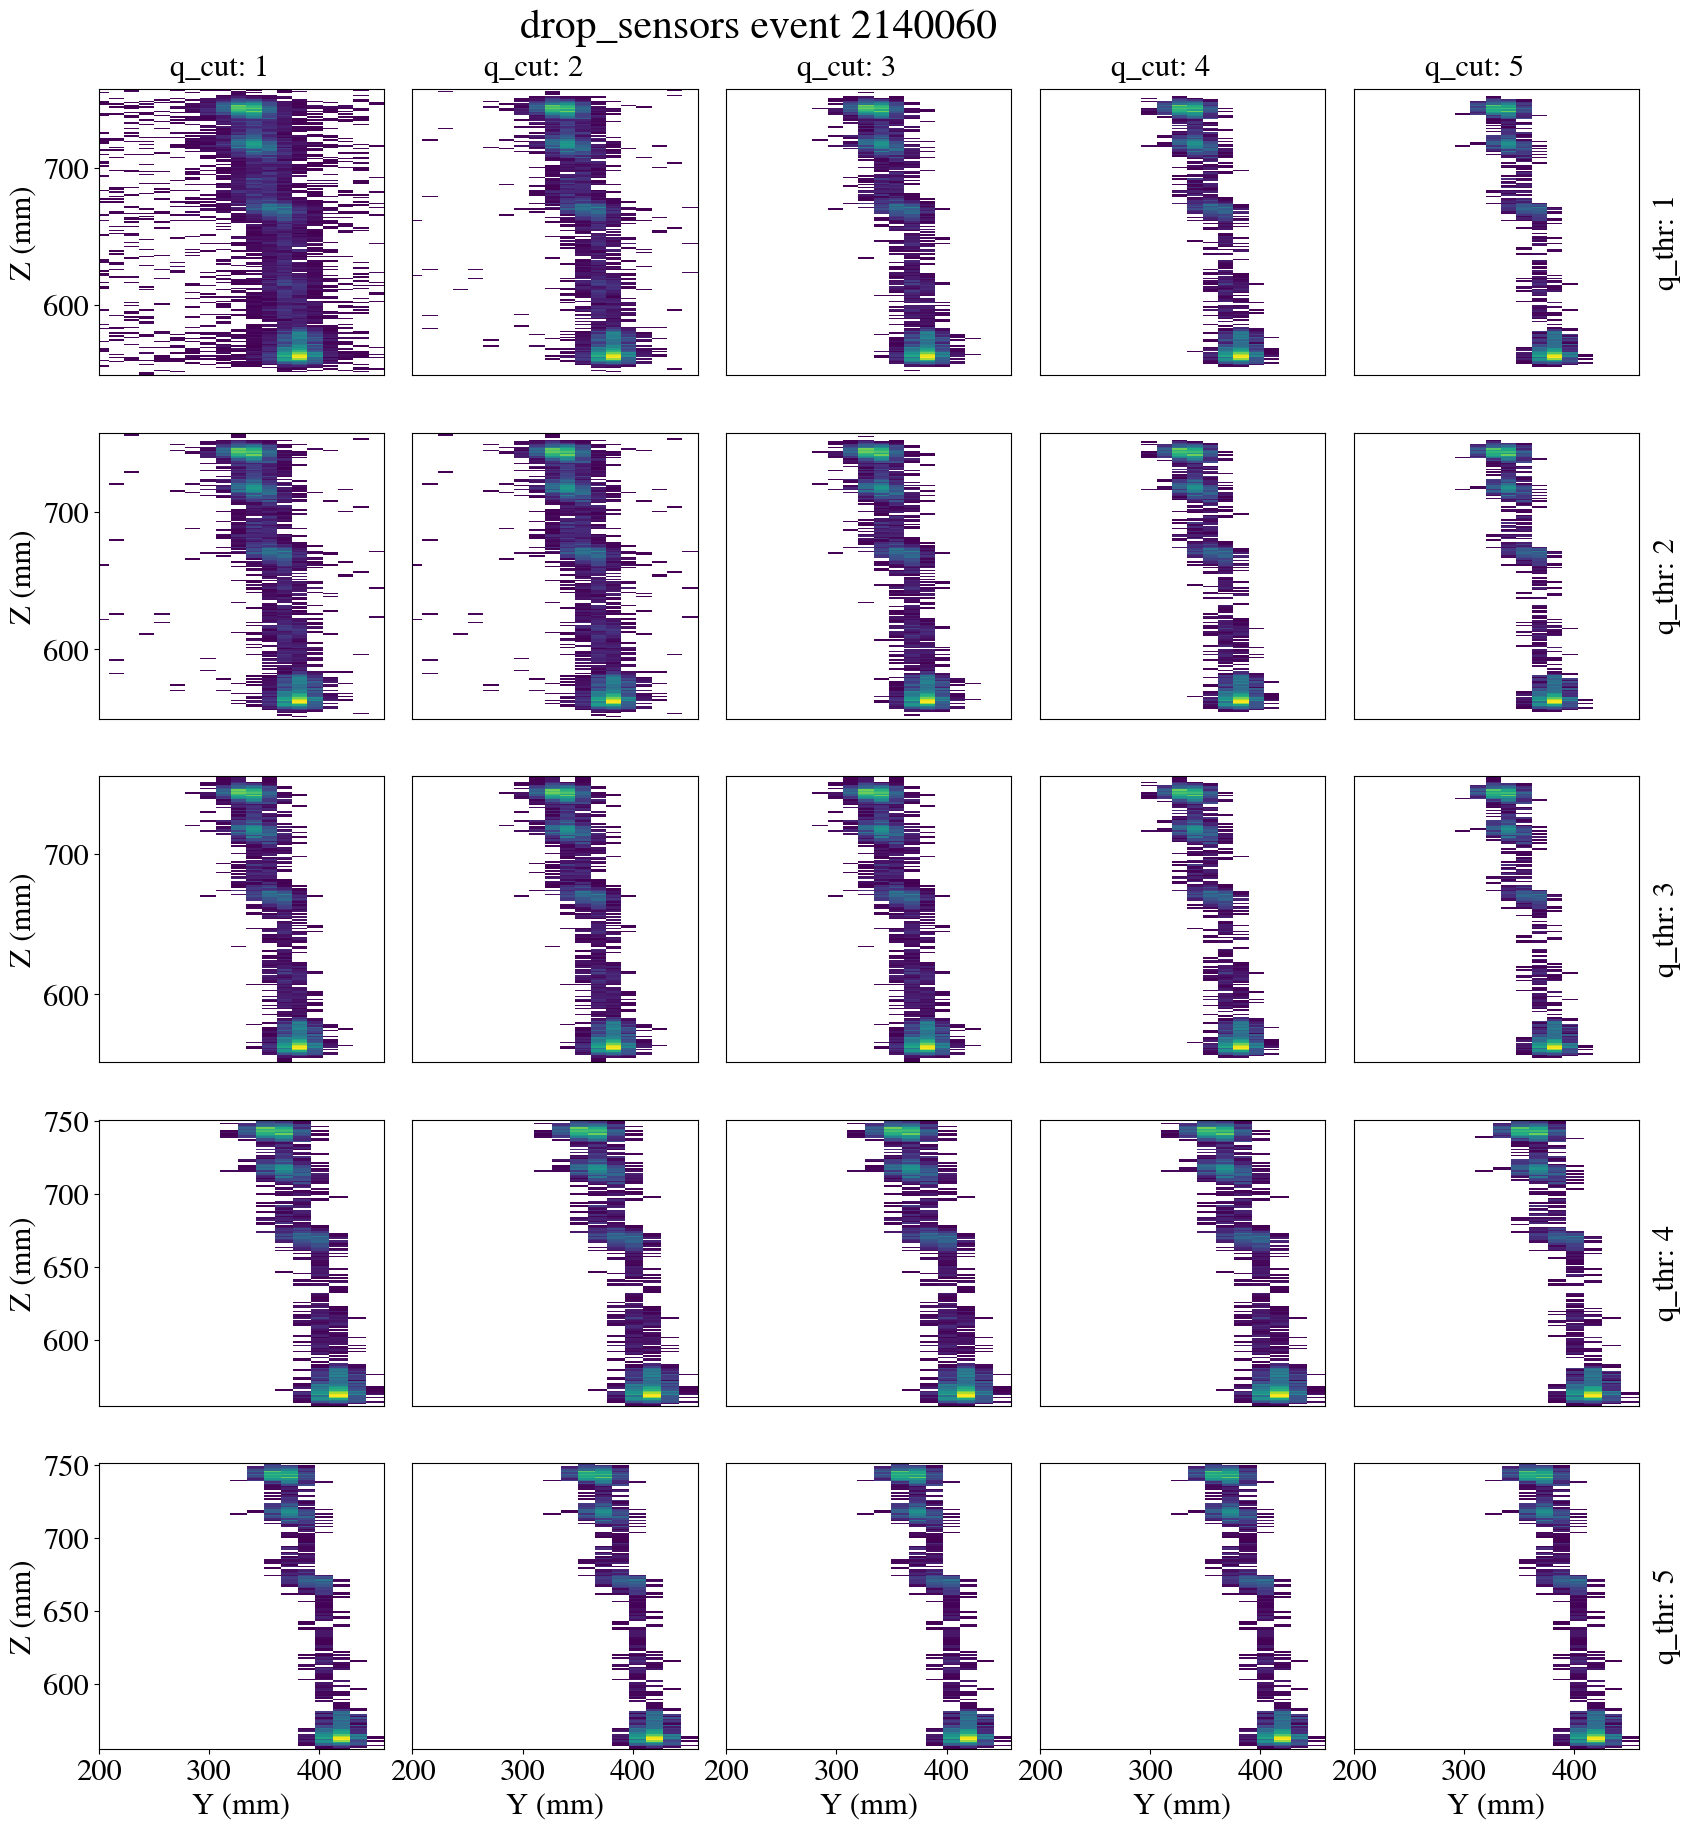

In [17]:
fig, axes = plt.subplots(5, 5, figsize = (22,20))
for i in range(len(thresholds)):
    for j in range(len(thresholds)):
        h_Y = data_array[i][j][1][0]
        h_Z = data_array[i][j][1][1]
        yy  = data_array[i][j][1][2]
        zz  = data_array[i][j][1][3]
        h_Q = data_array[i][j][1][4]

        axes[i][j].hist2d(h_Y, h_Z, bins=[yy, zz], weights=h_Q, cmin=0.0001);
        #axes[i][j].set_xlabel('Y (mm)');


        # threshold labels
        if (i == 0):
            axes[i][j].text(0.25, 1.05, "q_cut: " + str(thresholds[j]), transform=axes[i][j].transAxes)

        if (j == len(thresholds)-1):
            axes[i][j].text(1.125, 0.3, "q_thr: " + str(thresholds[i]), 
                            transform=axes[i][j].transAxes, 
                            rotation = 90, rotation_mode = 'anchor')



        if (i != len(thresholds)-1):
            axes[i][j].set_xticks([])
        else:
            axes[i][j].set_xlabel('Y (mm)')    
            

        if (j != 0):
            axes[i][j].set_yticks([])
        else:
            axes[i][j].set_ylabel('Z (mm)')

        axes[i][j].set_xlim(200)    
        
# test to understand where the axes actually are
#axes[4][0].text(0.25, 1.05, "test",transform=axes[4][0].transAxes)

fig.subplots_adjust(top = 0.94, wspace = 0.1,  left = 0.2, hspace = 0.2)
fig.suptitle('drop_sensors event ' + str(EVENT), fontsize=30)
fig.savefig(pre_dir_name + str('drop_sensor_zoom.png'))
plt.show()